In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun
from scipy.integrate import ode


## Generate Data
def f(t,state,par):
    σ,ρ,β = par
    x,y,z = state
    return np.array([σ*(y-x),
                  x*(ρ-z)-y,
                  x*y-β*z])

# Jacobian
def Df(t,state,par):
    σ,ρ,β = par
    x,y,z = state
    print(np.array([[-σ,σ,0],[ρ-z,-1,-x],[y,x,-β]]))
    return np.array([[-σ,σ,0],[ρ-z,-1,-x],[y,x,-β]])

step = 0.2
n_iter = 30
#t = np.arange(0, 100, step)
t_vals = np.arange(0,n_iter*step,step)
Y = np.empty((3, t_vals.size))
#Y[:,0] = np.array([1.508870,-1.531271,25.46091])

Y[:,0] = np.array([6.7673,6.1253,25.8706])
σ,ρ,β = 10,28,8.0/3.0

#state = odeint(f, y0, t, args=(σ,ρ,β))

r = ode(f).set_integrator('dopri5')
r.set_initial_value(Y[:,0], t_vals[0])
r.set_f_params((σ,ρ,β))

for i,t in enumerate(t_vals):
    if i == 0:
        continue
    r.integrate(t)
    Y[:,i] = r.y
    
np.random.seed(0)
yobs = Y.T  + np.random.normal(size=Y.T.shape) * 0.01 #* np.random.lognormal(mean=0,sigma=0.01,size=Y.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
#times = np.arange(1, len(t_vals) + 1).astype(float)
print(yobs.std(axis=0))
yobs_norm = yobs #/ yobs.std(axis=0)
#N = len(times)



## Do Bayesian Sindy
def lorenz_sunode_library(t, y, p):
    #np.array([y.x, y.yy])
    dx_dt = p.pn[0] * y.x + p.pn[1] * y.y + p.pn[7] * y.z
    dy_dt = p.pn[2] * y.x + p.pn[3] * y.x * y.z + p.pn[4] * y.y + p.pn[8] * y.z
    dz_dt = p.pn[5] * y.x * y.y + p.pn[6] * y.z + p.pn[9] * y.x
    return {'x': dx_dt - 1e-7 * y.x**3, 'y' : dy_dt - 1e-7 * y.y**3, 'z' : dz_dt - 1e-7 * y.z**3}

model_sunode = pm.Model()

d = 10


with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-3, sigma=1, shape=3)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.1)
    #c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    #lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=10, shape=d)
    pn = pm.Deterministic('pn', z*tau*l)
    #pn = pm.Normal('pn', mu=0, sigma=10, shape=d)
    
    y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=3) #pm.Lognormal('y0', mu=pm.math.log(10), sigma=1, shape=3)

    y_hat = sun.solve_ivp(
        y0={
            'x': (y0[0], ()),
            'y': (y0[1], ()),
            'z': (y0[2], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=lorenz_sunode_library,
    make_solver='BDF',
            tvals=t_vals,
            t0=t_vals[0],
        )[0]
    #import pysindy as ps
    #from pysindy.differentiation import SmoothedFiniteDifference
    #sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    #dx = sfd(inp)

    #dx / step        

        
    xobs = pm.Normal('xobs', mu=y_hat['x'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    yobs = pm.Normal('yobs', mu=y_hat['y'][:], sigma=sigma[1], observed=yobs_norm[:,1])
    zobs = pm.Normal('zobs', mu=y_hat['z'][:], sigma=sigma[2], observed=yobs_norm[:,2])
    
    #xobs = pm.Lognormal('xobs', mu=pm.math.log(y_hat['x'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    #yobs = pm.Lognormal('yobs', mu=pm.math.log(y_hat['y'][:]), sigma=sigma[1], observed=yobs_norm[:,1])
    #zobs = pm.Lognormal('zobs', mu=pm.math.log(y_hat['z'][:]), sigma=sigma[2], observed=yobs_norm[:,2])
    

with model_sunode:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    x = inp[:,0]
    y = inp[:,1]
    z = inp[:,2]

    θ = np.array([x,y,z,x*y,x*z]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0] / (t_vals[1] - t_vals[0])
    
    print('Initialization')
    print(guess)

    #start['pnss'] = start['pn']
    '''start['tau'] = 0.1
    start['sigma'] = 0.1 * np.ones(start['sigma'].shape)
    start['lt'] = (np.sqrt(start['c2'])*start['l']) / np.sqrt(start['c2'] + start['tau']**2 * start['l']**2)
    start['tau_log__'] = np.log(start['tau'])
    start['pn'] = guess.T
    start['z'] = start['pn'] / start['tau'] / start['lt']
    start['sigma_log__'] = np.log(start['sigma'])
    start['z_log__'] = np.log(start['z'])
    start['c2_log__'] = np.log(start['c2'])
    start['l_log__'] = np.log(start['l'])
    start['lt_log__'] = np.log(start['lt'])
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])'''


    start['tau'] = 0.1
    #start['c2'] = 5
    start['l'] = np.ones(start['l'].shape) * 10
    #start['sigma'] = 0.1 * np.ones(start['sigma'].shape)
    #start['tau_log__'] = np.log(start['tau'])
    #start['pn'] = guess.T

    start['pn'] = np.array([-σ, σ, ρ, -1, -1, 1, -β, 0.1, 0.1, 0.1])
    start['z'] = start['pn'] / start['tau'] / start['l']
    #start['z'] = np.sign(guess).flatten() 
    #start['lt'] = (np.sqrt(start['c2'])*start['l']) / np.sqrt(start['c2'] + start['tau']**2 * start['l']**2)
    #start['z'] = start['pn'] / start['tau'] / start['l'] # (np.sqrt(start['c2'])*start['l']) / np.sqrt(start['c2'] + start['tau']**2 * start['l']**2)
    #start['c2_log__'] = np.log(start['c2'])
    start['l_log__'] = np.log(start['l'])
    #start['lt_log__'] = np.log(start['lt']) 
    start['tau_log__'] = np.log(start['tau'])
    start['sigma'] = 0.01 * np.ones(3)
    start['sigma_log__'] = np.log(start['sigma'])
    #start['y0'] = yobs_norm[0,:]
    start['y0'] = yobs_norm[0,:]
    #start['y0_log__'] = np.log(start['y0'])
    #start['sigma_log__'] = np.log(start['sigma'])
    print(start)




    #trace = pm.sample(4000, tune=1000, cores=2, random_seed=0, target_accept=0.95, start=start)




    trace = pm.backends.load_trace('normal_distributed/lorenz_h_10param_attempt4' + '.trace',model_sunode)

#print(__file__)
#print('done')

[1.89181673 2.60846481 3.36269011]


logp = -270.79, ||grad|| = 0.051713: 100%|██████████| 203/203 [00:01<00:00, 136.04it/s] 
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:134: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Initialization
[[ 19.5705232  -20.54127019  83.54057635]
 [ -5.96151623  10.14486587 -31.12392811]
 [ -1.55678072   1.57526696  -6.56588463]
 [  0.1387638   -0.35767186   0.89474461]
 [ -0.36279914   0.31776686  -1.45437579]]
{'sigma_log__': array([-4.60517019, -4.60517019, -4.60517019]), 'l_log__': array([2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509,
       2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509]), 'tau_log__': -2.3025850929940455, 'z': array([-10.        ,  10.        ,  28.        ,  -1.        ,
        -1.        ,   1.        ,  -2.66666667,   0.1       ,
         0.1       ,   0.1       ]), 'y0': array([ 6.78494052,  6.12930157, 25.88038738]), 'sigma': array([0.01, 0.01, 0.01]), 'l': array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]), 'tau': 0.1, 'pn': array([-10.        ,  10.        ,  28.        ,  -1.        ,
        -1.        ,   1.        ,  -2.66666667,   0.1       ,
         0.1       ,   0.1       ])}


In [2]:
#pm.plot_trace(trace,compact=False)

([], <a list of 0 Text major ticklabel objects>)

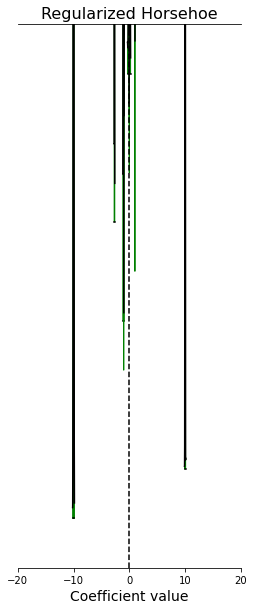

In [3]:
plt.figure(figsize=(4,10))
ax = plt.subplot(1,1,1)
ax.plot([0, 0], [-0.05, 0.5], 'k--')
pm.forestplot((trace['pn']).T, credible_interval=0.95, kind='ridgeplot', colors='green', ridgeplot_overlap=50, ax=ax)
#ax.set_title('')
#ax.set_xlabel('Coefficient value')
#ax.set_ylabel('Coefficient')
ax.set_xlim(-20, 20)
ax.set_ylim(-0.05, 0.5)
#ax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85)
#ax.set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)

ax.set_xlabel('Coefficient value', fontsize=14)
plt.title('Regularized Horsehoe', fontsize=16)
plt.yticks([])    
#ax.plot

In [4]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],-10.892,1.295,-12.976,-9.243,0.867,0.718,2.0,2.0,2.0,11.0,2.44
z[1],10.905,0.973,9.921,12.546,0.669,0.560,2.0,2.0,2.0,13.0,2.38
z[2],23.824,2.689,19.209,28.145,1.634,1.310,3.0,3.0,3.0,14.0,1.76
z[3],-1.050,0.083,-1.223,-0.946,0.051,0.041,3.0,3.0,3.0,34.0,2.15
z[4],-1.222,0.152,-1.432,-1.005,0.103,0.086,2.0,2.0,3.0,23.0,2.15
z[5],1.069,0.165,0.742,1.317,0.054,0.039,9.0,9.0,9.0,21.0,1.16
z[6],-2.819,0.353,-3.544,-2.476,0.227,0.186,2.0,2.0,2.0,13.0,2.57
z[7],0.010,0.037,-0.029,0.093,0.021,0.017,3.0,3.0,5.0,23.0,1.41
z[8],-0.072,0.058,-0.157,0.022,0.037,0.030,2.0,2.0,3.0,11.0,2.12
z[9],-0.022,0.078,-0.157,0.136,0.017,0.012,22.0,22.0,22.0,35.0,1.06


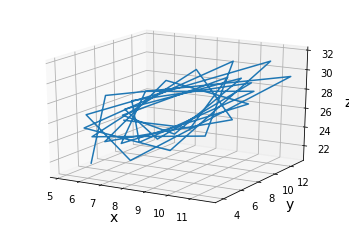

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=x, ys=y, zs=z)
plt.ylabel('y', fontsize=14)
plt.xlabel('x', fontsize=14)
ax.set_zlabel('z', fontsize=14)
# rotate the axes and update
ax.view_init(20)

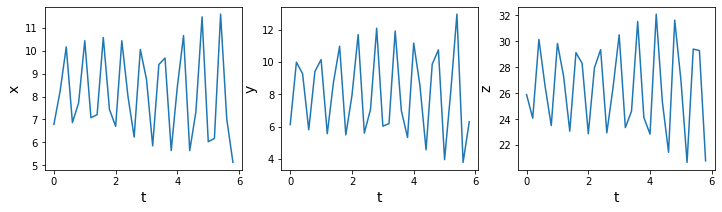

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(t_vals,x)
plt.ylabel('x', fontsize=14)
plt.xlabel('t',fontsize=14)

plt.subplot(1,3,2)
plt.plot(t_vals,y)
plt.ylabel('y', fontsize=14)
plt.xlabel('t',fontsize=14)

plt.subplot(1,3,3)
plt.plot(t_vals,z)
plt.ylabel('z',fontsize=14)
plt.xlabel('t',fontsize=14)
plt.show()